In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
import sys
sys.path.append('../../src')

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from nets.detector_MTCNN import DetectorMTCNN
from nets import cnn_recognition
import shutil
import random
from tqdm import tqdm
import time

In [28]:
img_width, img_height = 224, 224

database = '../../data/wisenet_dataset/database_frames'
dataset = '../../data/wisenet_dataset/dataset_mobilenet'
train_dataset = '../../data/wisenet_dataset/train_dataset_mobilenet'

labels_class_file = '../../models/labels.txt'
saved_model_dir = '../../models/mobilenet'

train_data = os.path.join(train_dataset, 'train')
validation_data = os.path.join(train_dataset, 'test')

batch_size = 32
initial_epochs = 22
test_size=.3

In [5]:
if os.path.exists(dataset):
    shutil.rmtree(dataset)

if os.path.exists(train_dataset):
    shutil.rmtree(train_dataset)

In [6]:
detector_MTCNN = DetectorMTCNN(img_width, img_height)

In [7]:
detector_MTCNN.crop_align(database, dataset)

  0%|          | 0/605 [00:00<?, ?it/s]

100%|██████████| 605/605 [03:22<00:00,  2.99it/s]


In [8]:
os.makedirs(train_dataset)

ref = 1

for root, dirs, files in tqdm(os.walk(dataset)):
    if len(dirs) > 1:
        for person in dirs:
            root = '{}/{}/'.format(dataset, person )

            output_train_dir = '{}/{}'.format(train_data, person)
            if not os.path.exists(os.path.join(output_train_dir)):
                os.makedirs(output_train_dir)

            output_test_dir = '{}/{}'.format(validation_data, person)
            if not os.path.exists(output_test_dir):
                os.makedirs(output_test_dir)

            files = os.listdir(root)
            test = random.sample(files, int(len(files) * test_size))
            train = list(set(files) - set(test))
            for copy_test in test:
                shutil.copy(os.path.join(root, copy_test),os.path.join(output_test_dir, copy_test))

            for copy_train in train:
                shutil.copy(os.path.join(root, copy_train), os.path.join(output_train_dir, copy_train))

7it [00:00, 86.19it/s]


In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    zoom_range=0.1,  
    width_shift_range=0.1,
    height_shift_range=0.1,
    vertical_flip=False,
    horizontal_flip=True)


test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')


Found 394 images belonging to 6 classes.
Found 164 images belonging to 6 classes.


In [10]:
for image_batch, label_batch in train_generator:
    break

print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open(labels_class_file, 'w') as f:
    f.write(labels)

{'ID1': 0, 'ID12': 1, 'ID15': 2, 'ID16': 3, 'ID3': 4, 'UNK': 5}


In [22]:
cnn_recognition_net = cnn_recognition.Net(output_class=len(train_generator.class_indices))

In [23]:
cnn_recognition_net.model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy']) 
cnn_recognition_net.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 5, 32)          368672    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 32)          0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 198       
Total params: 2,626,854
Trainable params: 368,870
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
print('Number of trainable variables = {}'.format(len(cnn_recognition_net.model.trainable_variables)))

Number of trainable variables = 4


In [25]:
begin = time.time()
history = cnn_recognition_net.model.fit(train_generator, epochs=initial_epochs,validation_data=validation_generator)
end = time.time()
print("Time to training: {} s".format(int(end-begin)))

Epoch 1/22
13/13 [==============================] - 15s 949ms/step - loss: 3.3393 - accuracy: 0.3426 - val_loss: 1.5613 - val_accuracy: 0.3293
Epoch 2/22
13/13 [==============================] - 19s 2s/step - loss: 1.3565 - accuracy: 0.4797 - val_loss: 1.4126 - val_accuracy: 0.5610
Epoch 3/22
13/13 [==============================] - 19s 1s/step - loss: 1.1802 - accuracy: 0.5787 - val_loss: 1.2634 - val_accuracy: 0.6098
Epoch 4/22
13/13 [==============================] - 24s 2s/step - loss: 1.0016 - accuracy: 0.6421 - val_loss: 1.1710 - val_accuracy: 0.6098
Epoch 5/22
13/13 [==============================] - 19s 2s/step - loss: 0.9360 - accuracy: 0.6497 - val_loss: 1.0585 - val_accuracy: 0.6524
Epoch 6/22
13/13 [==============================] - 19s 1s/step - loss: 0.8687 - accuracy: 0.6878 - val_loss: 0.9316 - val_accuracy: 0.6768
Epoch 7/22
13/13 [==============================] - 19s 1s/step - loss: 0.8828 - accuracy: 0.7005 - val_loss: 0.8950 - val_accuracy: 0.7500
Epoch 8/22
13/13 

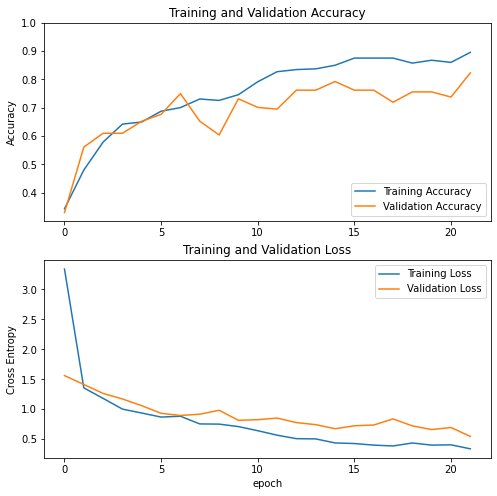

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [29]:
cnn_recognition_net.model.save(saved_model_dir)

/home/jarvis/miniconda3/envs/tcc-25/lib/python3.6/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: ../../models/mobilenet/assets


INFO:tensorflow:Assets written to: ../../models/mobilenet/assets
